In [1]:
#| include: false
# 以下都是例行公事，直接拷贝即可

import pandas as pd
import numpy as np 

# 导入matplotlib.pyplot绘图库，其中plt.plot()是最常用的绘图函数之一
import matplotlib.pyplot as plt 

import seaborn as sns

sns.set() # 默认用seaborn的绘图样式

plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体。如果不设置，中文会乱码。这里采用微软雅黑'Microsoft YaHei'，如果显示不正常，也可以使用黑体'SimHei'或者宋体'SimSun'等
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 绘图使用'svg'后端：svg是矢量格式，可以任意缩放均保持清晰，各种屏幕的显示良好。
%config InlineBackend.figure_formats = ['svg']

# 技术分析交易策略

传统的技术分析技术怎么在Python中应用，包括绘制指标，以及交易的回测。

主要包括：

1. 趋势交易：双均线系统为例
2. 波动交易：RSI系统为例
3. 指标综合：结合前两者

注意：以下策略均未考虑交易成本。如果要考虑，只要在交易日乘以一个系数(1-交易成本)即可。

## 简单移动平均策略

从最简单的双均线交易系统开始：设置2条均线，当快速均线位于慢速均线上方，则持有；反之则空仓。

1. 绘制均线
2. 计算交易信号
3. 计算交易的收益率
4. 绘制交易结果

### 读取数据

这里简单演示一下如何用akshare包来读取数据。akshare官方主页见https://www.akshare.xyz/。

如果要在你的电脑上安装akshare包（这里采用清华大学的镜像），有几种方法：

1. 在jupyter notebook中，找一个python单元格，然后粘贴如下代码，并执行:

```
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple akshare
```

2. 启动Anaconda Prompt（开始菜单中有），或者Mac系统的终端(Terminal)，执行如下命令，则会从清华大学的镜像安装akshare到你的电脑上。

```
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple akshare
```

上述方法2选1，并且都只需要执行一次，以后都可以使用。

In [2]:
import akshare as ak

这里以锂电池龙头宁德时代为例。

In [3]:
# 读取宁德时代
# 见：https://akshare.xyz/data/stock/stock.html#id20

df = ak.stock_zh_a_hist(symbol="300750",start_date='20180101',end_date='20231212', adjust='qfq')

df

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2018-06-11,14.66,18.01,18.01,14.66,788,2.845471e+06,28.22,51.73,6.14,0.04
1,2018-06-12,20.02,20.02,20.02,20.02,266,1.058375e+06,0.00,11.16,2.01,0.01
2,2018-06-13,22.24,22.24,22.24,22.24,450,1.972314e+06,0.00,11.09,2.22,0.02
3,2018-06-14,24.67,24.67,24.67,24.67,743,3.578184e+06,0.00,10.93,2.43,0.03
4,2018-06-15,27.35,27.35,27.35,27.35,2565,1.359503e+07,0.00,10.86,2.68,0.12
...,...,...,...,...,...,...,...,...,...,...,...
1334,2023-12-06,158.65,162.88,166.86,158.22,367693,6.024340e+09,5.44,2.56,4.07,0.94
1335,2023-12-07,162.00,164.49,166.36,161.60,269084,4.410842e+09,2.92,0.99,1.61,0.69
1336,2023-12-08,165.00,163.59,166.33,163.12,245020,4.030383e+09,1.95,-0.55,-0.90,0.63
1337,2023-12-11,162.01,165.35,165.69,160.16,214896,3.497266e+09,3.38,1.08,1.76,0.55


需要前置知识：对数收益率。见上一章：[组合的预期收益和方差](https://py4ss.net/python/34-portfolio.html#%E7%BB%84%E5%90%88%E7%9A%84%E9%A2%84%E6%9C%9F%E6%94%B6%E7%9B%8A%E5%92%8C%E6%96%B9%E5%B7%AE)的内容。

正如前面所说，使用涨跌幅就不用考虑分红、送股、复权等问题。

In [4]:
df['日期'] = pd.to_datetime(df['日期'])
df.set_index('日期',inplace = True)

In [5]:
df = df[['涨跌幅']]/100
df.fillna(0,inplace=True)
df.tail()

,涨跌幅
日期,
2023-12-06,0.0256
2023-12-07,0.0099
2023-12-08,-0.0055
2023-12-11,0.0108
2023-12-12,-0.0104


从上市之日，投资1元到今天的结果。

In [6]:
df['price'] = (df['涨跌幅'] + 1).cumprod() # 用涨跌幅反算出复权价，上市日前一天为1。
df

,涨跌幅,price
日期,,
2018-06-11,0.5173,1.517300
2018-06-12,0.1116,1.686631
2018-06-13,0.1109,1.873678
2018-06-14,0.1093,2.078471
2018-06-15,0.1086,2.304193
...,...,...
2023-12-06,0.0256,13.678666
2023-12-07,0.0099,13.814085
2023-12-08,-0.0055,13.738107


<Axes: xlabel='日期'>

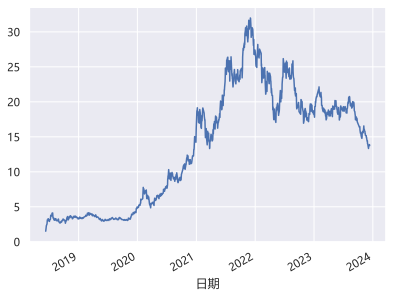

In [7]:
df.price.plot()

In [8]:
# 计算对数收益率
df['lrets'] = np.log(df['涨跌幅'] + 1)
df.tail()

,涨跌幅,price,lrets
日期,,,
2023-12-06,0.0256,13.678666,0.025278
2023-12-07,0.0099,13.814085,0.009851
2023-12-08,-0.0055,13.738107,-0.005515
2023-12-11,0.0108,13.886479,0.010742
2023-12-12,-0.0104,13.742059,-0.010454


In [9]:
# 计算年化对数收益率

np.mean(df.lrets) * 250

0.48925712358901946

In [10]:
# 年化对数SD
np.std(df.lrets) * np.sqrt(250)

0.5246989273782676

In [11]:
# 简单算一下夏普比率: 每单位风险，能够获得多少超额收益。
rf = 0.03

(np.mean(df.lrets) * 250 - rf) / (np.std(df.lrets) * np.sqrt(250))

0.8752774202984608

In [12]:
# 写成函数
def sharpe_ratio(lrets, rf = 0.03):
    return (np.mean(lrets) * 250 - rf) / (np.std(lrets) * np.sqrt(250))

sharpe_ratio(df.lrets)

0.8752774202984608

### 均线计算

绘制均线，先随选2个日期

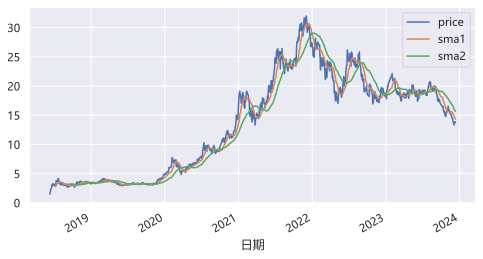

In [13]:
sma1 = 20
sma2 = 60

def sma(x,period):
    return x.rolling(period).mean()

def ema(x,period):
    return x.ewm(span=period,min_periods=0,adjust=False,ignore_na=False).mean()

df.loc[:,'sma1'] = sma(df.price,sma1)
df.loc[:,'sma2'] = sma(df.price,sma2)

df[['price','sma1','sma2']].plot(figsize=(8,4));

### 交易策略(多)

首先假定我们只能做多。

如果快均线高于慢均线：买入持有；反之空仓。


In [14]:
df['pos'] = np.where(df['sma1'] > df['sma2'],1,0) # np.where()生成一个序列，条件成立则1，反之则0
df.tail()

,涨跌幅,price,lrets,sma1,sma2,pos
日期,,,,,,
2023-12-06,0.0256,13.678666,0.025278,14.758742,16.025914,0
2023-12-07,0.0099,13.814085,0.009851,14.645452,15.928012,0
2023-12-08,-0.0055,13.738107,-0.005515,14.538493,15.839902,0
2023-12-11,0.0108,13.886479,0.010742,14.443875,15.759274,0
2023-12-12,-0.0104,13.742059,-0.010454,14.359551,15.678205,0


把指标和持仓情况并列绘制

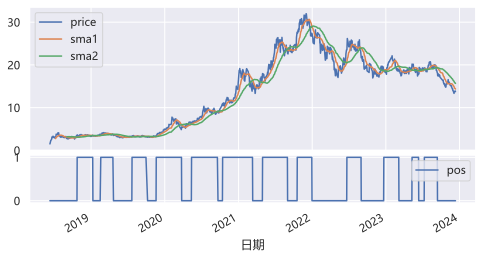

In [15]:
# 绘制子图，见前面的章节。height_ratios是子图的高度比例
fig, axes = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [3, 1]},sharex = True)

df[['price','sma1','sma2']].plot(ax = axes[0])
df[['pos']].plot(ax = axes[1])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

计算策略的收益率序列。

1. `df['pos']`中，1表示持仓，0表示空仓
2. `df['lrets']`表示每天的对数收益率。
3. `df['lrets'] * df.lrets`，两个序列相乘，就可以得到执行策略的收益率序列：空仓日收益率为0，持仓日收益率为lret。
4. 今天出信号，收盘进行操作，实际收益在明天才能兑现。因此pos要滞后1天（**重要**：避免自我欺骗）


In [16]:
df['strategy'] = df['pos'].shift(1) * df.lrets

df.dropna(inplace=True)

df.round(4).head()

,涨跌幅,price,lrets,sma1,sma2,pos,strategy
日期,,,,,,,
2018-09-03,-0.0362,2.7843,-0.0369,3.1110,3.1371,0,-0.0
2018-09-04,0.0097,2.8113,0.0097,3.0877,3.1587,0,0.0
2018-09-05,-0.0408,2.6966,-0.0417,3.0640,3.1755,0,-0.0
2018-09-06,0.0078,2.7177,0.0078,3.0354,3.1896,0,0.0
2018-09-07,0.0254,2.7867,0.0251,3.0093,3.2014,0,0.0


比较一下两者:

（注意我们的均线是随意选择的）

In [17]:
# 年化对数收益率
df[['lrets','strategy']].agg(np.mean)*250

lrets       0.304606
strategy    0.204169
dtype: float64

In [18]:
# 夏普比率
df[['lrets','strategy']].agg(sharpe_ratio)

lrets       0.584413
strategy    0.478580
dtype: float64

绘制两者的对比曲线：正如均线系统的特征，能够过滤掉大幅度的下跌，对顶部和底部的判断有明显的滞后。

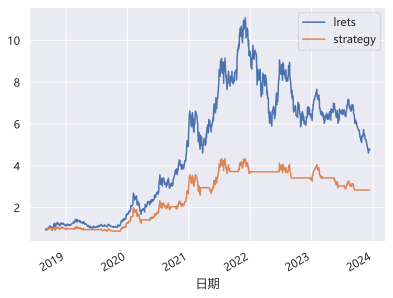

In [19]:
df[['lrets','strategy']].cumsum().apply(np.exp).plot();

### 使用暴力优化

参数优化：寻找最佳参数

暴力参数优化：使用穷举法，寻找最佳参数。


In [20]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

sma1 = 10
sma2 = 60
data = df[['price','lrets']]

# def test(sma1, sma2, data):
data['sma1'] = sma(data.price, sma1)
data['sma2'] = sma(data.price, sma2)

data['pos'] = np.where(data['sma1'] > data['sma2'], 1, 0)

data['strategy'] = data['pos'].shift(1) * data.lrets

data.dropna(inplace = True)

data.head()

,price,lrets,sma1,sma2,pos,strategy
日期,,,,,,
2018-12-03,3.605193,0.010841,3.453723,3.211778,1,0.000000
2018-12-04,3.672610,0.018527,3.474819,3.226583,1,0.018527
2018-12-05,3.629641,-0.011769,3.487499,3.240221,1,-0.011769
2018-12-06,3.519300,-0.030872,3.492613,3.253932,1,-0.030872
2018-12-07,3.551325,0.009059,3.519380,3.267826,1,0.009059


要获得这几样

1. 股票原来的年化收益率和年化夏普比率
2. 含有交易策略的年化收益率和年化夏普比率

In [21]:
asset_rets = np.mean(data.lrets) * 250
asset_sr = sharpe_ratio(data.lrets)

strat_rets = np.mean(data.strategy) * 250
start_sr = sharpe_ratio(data.strategy)

result = pd.DataFrame(dict(asset_rets=asset_rets,
                           asset_sr=asset_sr,
                           strat_rets=strat_rets,
                           start_sr=start_sr,
                           diff_rets = strat_rets - asset_rets,
                           diff_sr= start_sr - asset_sr
                           ), index=[0])

result


,asset_rets,asset_sr,strat_rets,start_sr,diff_rets,diff_sr
0,0.276193,0.533842,0.211045,0.506226,-0.065148,-0.027616


In [22]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

def test(sma1, sma2, data):
    data['sma1'] = sma(data.price, sma1)
    data['sma2'] = sma(data.price, sma2)

    data['pos'] = np.where(data['sma1'] > data['sma2'], 1, 0)

    data['strategy'] = data['pos'].shift(1) * data.lrets

    data.dropna(inplace = True)

    asset_rets = np.mean(data.lrets) * 250
    asset_sr = sharpe_ratio(data.lrets)

    strat_rets = np.mean(data.strategy) * 250
    start_sr = sharpe_ratio(data.strategy)

    result = pd.DataFrame(dict(sma1 = sma1 ,sma2=sma2, 股票收益率=asset_rets,
                            股票sr=asset_sr,
                            策略收益率=strat_rets,
                            策略sr=start_sr,
                            收益率差异 = strat_rets - asset_rets,
                            sr差异= start_sr - asset_sr
                            ), index=[0])

    return result

循环并罗列所有结果

In [23]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

from itertools import product

sma1 = range(10,56,5) 
sma2 = range(60,251,10)

result = []
for SMA1, SMA2 in product(sma1,sma2):
    #print(f"{SMA1=},{SMA2=}")
    result.append(test(SMA1, SMA2, df[['price','lrets']]))

pd.concat(result).sort_values('策略sr',ascending=False).head(5)


,sma1,sma2,股票收益率,股票sr,策略收益率,策略sr,收益率差异,sr差异
0,25,190,0.337937,0.653594,0.405723,0.972937,0.067786,0.319343
0,25,250,0.335876,0.637902,0.414782,0.950885,0.078905,0.312983
0,30,220,0.324652,0.619137,0.392126,0.917412,0.067474,0.298275
0,30,250,0.335876,0.637902,0.398393,0.910891,0.062517,0.272989
0,25,200,0.341073,0.657791,0.383528,0.907771,0.042456,0.249979


利用暴力求解（穷举法），可以得到任何2组均线的策略收益率和策略夏普比率。可以带入前面的代码查看效果。

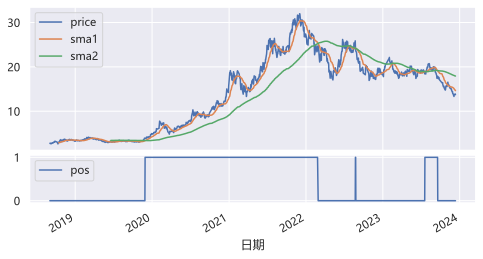

In [24]:
sma1 = 25
sma2 = 190
df.loc[:,'sma1'] = sma(df.price,sma1)
df.loc[:,'sma2'] = sma(df.price,sma2)

df['pos'] = np.where(df['sma1'] > df['sma2'],1,0)

fig, axes = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [3, 1]},sharex = True)
df[['price','sma1','sma2']].plot(ax = axes[0])
df[['pos']].plot(ax = axes[1])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

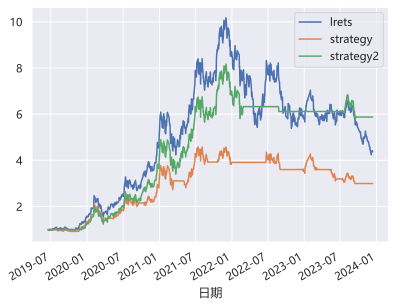

In [25]:
df.loc[:,'strategy2'] = df['pos'].shift(1) * df.lrets

df.dropna(inplace=True)

df.round(4).head()

df[['lrets','strategy','strategy2''']].cumsum().apply(np.exp).plot();

### 交易策略（多空）

In [26]:
df['pos'] = np.where(df['sma1'] > df['sma2'],1,-1) # np.where()生成一个序列，条件成立则1，反之则-1
df.tail()

,涨跌幅,price,lrets,sma1,sma2,pos,strategy,strategy2
日期,,,,,,,,
2023-12-06,0.0256,13.678666,0.025278,15.009210,18.044793,-1,0.0,0.0
2023-12-07,0.0099,13.814085,0.009851,14.938347,18.018929,-1,0.0,0.0
2023-12-08,-0.0055,13.738107,-0.005515,14.858149,17.990733,-1,-0.0,-0.0
2023-12-11,0.0108,13.886479,0.010742,14.751517,17.966012,-1,0.0,0.0
2023-12-12,-0.0104,13.742059,-0.010454,14.658707,17.940159,-1,-0.0,-0.0


In [27]:
def test2(sma1, sma2, data):
    data['sma1'] = sma(data.price, sma1)
    data['sma2'] = sma(data.price, sma2)

    data['pos'] = np.where(data['sma1'] > data['sma2'], 1, -1) # 这里改了一下

    data['strategy'] = data['pos'].shift(1) * data.lrets

    data.dropna(inplace = True)

    asset_rets = np.mean(data.lrets) * 250
    asset_sr = sharpe_ratio(data.lrets)

    strat_rets = np.mean(data.strategy) * 250
    start_sr = sharpe_ratio(data.strategy)

    result = pd.DataFrame(dict(sma1 = sma1 ,sma2=sma2, 股票收益率=asset_rets,
                            股票sr=asset_sr,
                            策略收益率=strat_rets,
                            策略sr=start_sr,
                            收益率差异 = strat_rets - asset_rets,
                            sr差异= start_sr - asset_sr
                            ), index=[0])

    return result

In [28]:
%%capture --no-display 
# 这一行用于忽略本cell的warning

from itertools import product

sma1 = range(10,56,5) 
sma2 = range(60,251,10)

result = []
for SMA1, SMA2 in product(sma1,sma2):
    #print(f"{SMA1=},{SMA2=}")
    result.append(test2(SMA1, SMA2, df[['price','lrets']]))

pd.concat(result).sort_values('策略sr',ascending=False).head(5)

,sma1,sma2,股票收益率,股票sr,策略收益率,策略sr,收益率差异,sr差异
0,25,190,0.257870,0.485916,0.547773,1.106469,0.289904,0.620553
0,25,200,0.263642,0.496515,0.506072,1.013418,0.242431,0.516903
0,15,200,0.263642,0.496515,0.479052,0.955670,0.215411,0.459155
0,20,200,0.263642,0.496515,0.476580,0.950389,0.212939,0.453874
0,30,200,0.263642,0.496515,0.470273,0.936916,0.206632,0.440400


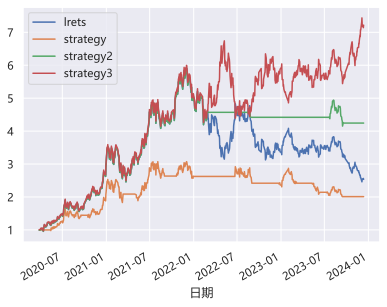

In [29]:
sma1 = 25
sma2 = 190
df.loc[:,'sma1'] = sma(df.price,sma1)
df.loc[:,'sma2'] = sma(df.price,sma2)

df['pos'] = np.where(df['sma1'] > df['sma2'],1,-1)

df['strategy3'] = df['pos'].shift(1) * df.lrets

df.dropna(inplace=True)

df.round(4).head()

df[['lrets','strategy','strategy2','strategy3']].cumsum().apply(np.exp).plot();

### 注意事项

1. 过去不代表未来，过去几年的最优策略，未来不一定成功（其实是基本不会成功）。
2. 可以考虑采用滚动的窗口测试（略）

## 摆动指标

这里以RSI指标为例。

In [30]:
def rsi(close, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [31]:
# 先把数据还原一下
df = df[['lrets','price']]
df

,lrets,price
日期,,
2020-03-27,-0.007931,5.377030
2020-03-30,0.005286,5.405529
2020-03-31,0.009257,5.455800
2020-04-01,0.000000,5.455800
2020-04-02,0.027031,5.605289
...,...,...
2023-12-06,0.025278,13.678666
2023-12-07,0.009851,13.814085
2023-12-08,-0.005515,13.738107


RSI指标的周期，我们暂定为14天。（显然这个值也是可以被优化的）

In [32]:
rsi_14 = rsi(df.price)
rsi_14[-5:]

日期
2023-12-06    29.395351
2023-12-07    32.657186
2023-12-08    31.770354
2023-12-11    35.456444
2023-12-12    33.556135
Name: price, dtype: float64

绘图：

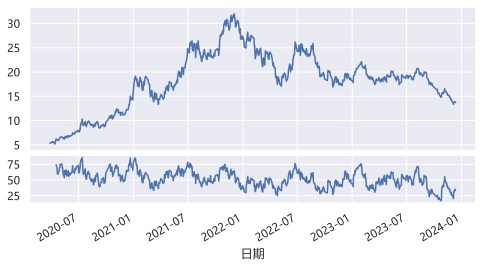

In [33]:
fig, axes = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [3, 1]},sharex = True)

df.price.plot(ax = axes[0])
rsi_14.plot(ax = axes[1])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

简单的RSI指标策略：

1. RSI小于某个值：买入，并持有到卖出。
2. RSI大于某个值：卖出，并等待到买入。

这里随便选择2个阈值：（连同rsi的周期，现在有3个可优化的值）


对于这种“买入卖出信号”的类型，如何计算持仓状态？

1. 从第一天开始，遍历每一天。
2. 检查买入信号是否为1，是，则position[i] = 1；
3. 检查卖出信号是否为1，是，则position[i] = 0；
4. 2个信号都不存在，则保持前值。

注意：

1. 这里的参数是随便选的，这里只是做演示。
2. 任何其他摆动指标，比如kdj，做法类似

In [34]:
# 构造买卖信号
long_signal = (rsi_14 < 35)
short_signal = (rsi_14 > 70)

In [35]:
position = np.zeros_like(rsi_14)  # 创建一个rsi_14同等长度的序列，其中填满0，即默认空仓


# 遍历rsi_14，这里其实只是要个序号i = [0,1,2,3, .... ]
for i in range(len(rsi_14)):
    if np.isnan(long_signal[i]) or np.isnan(short_signal[i]):  # 2个信号有1个是na，就保持0
        position[i] = 0
    else:
        if long_signal[i]:  # 如果i这天有买入信号
            position[i] = 1  # i这天的持仓为1
        elif short_signal[i]:  # 如果i这个天有卖出信号
            position[i] = 0  # i这天的持仓为0
        else:
            position[i] = position[i-1] # 没信号，则持仓状态不变

df['pos'] = pd.DataFrame({'pos': position}, index=rsi_14.index) # 构造一个时间序列的DataFrame
df

/tmp/ipykernel_50089/3571062792.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = pd.DataFrame({'pos': position}, index=rsi_14.index) # 构造一个时间序列的DataFrame


,lrets,price,pos
日期,,,
2020-03-27,-0.007931,5.377030,0.0
2020-03-30,0.005286,5.405529,0.0
2020-03-31,0.009257,5.455800,0.0
2020-04-01,0.000000,5.455800,0.0
2020-04-02,0.027031,5.605289,0.0
...,...,...,...
2023-12-06,0.025278,13.678666,1.0
2023-12-07,0.009851,13.814085,1.0
2023-12-08,-0.005515,13.738107,1.0


绘图：

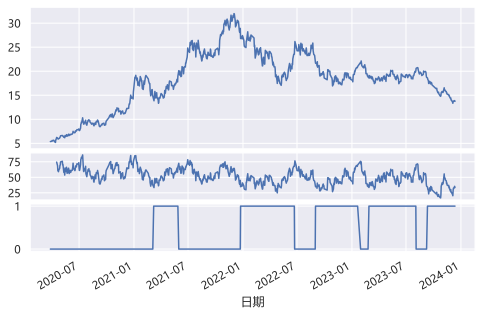

In [36]:
fig, axes = plt.subplots(3,1,figsize=(8,5), gridspec_kw={'height_ratios': [3, 1,1]},sharex = True)

df.price.plot(ax = axes[0])
rsi_14.plot(ax = axes[1])
df.pos.plot(ax = axes[2])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

In [37]:
np.mean(df.lrets * df.pos.shift(1)) * 250

0.025428265695020356

In [38]:
sharpe_ratio(df.lrets)

0.4859163275744956

In [39]:
sharpe_ratio(df.lrets * df.pos.shift(1))

-0.014897562318840355

In [40]:
df.loc[:,'strat_rets'] = df.lrets * df.pos.shift(1)

/tmp/ipykernel_50089/678097258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'strat_rets'] = df.lrets * df.pos.shift(1)


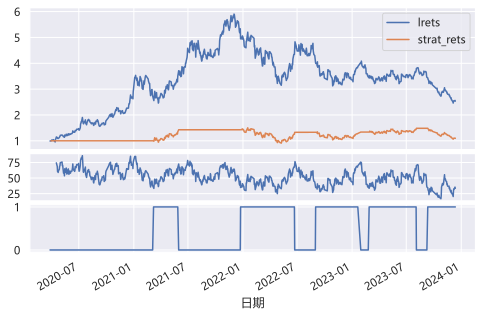

In [41]:
fig, axes = plt.subplots(3,1,figsize=(8,5), gridspec_kw={'height_ratios': [3, 1,1]},sharex = True)

df[['lrets','strat_rets']].cumsum().agg(np.exp).plot(ax = axes[0])
rsi_14.plot(ax = axes[1])
df.pos.plot(ax = axes[2])

plt.subplots_adjust(wspace=0.05,hspace=0.05)

可以优化的参数有三个，这些参数在本案中都是随机选取的:

1. 天数
2. 买入阈值
3. 卖出阈值

做法和均线系统完全一样，只是从2个参数变成3个参数，这里从略。

稍微扩展一下：

1. 在上升周期，RSI买卖信号的两个阈值可以提高（超买可以继续涨，回调不会跌太深），避免过早卖出，或者等不到买点；反之，两个信号的阈值可以降低。
2. 那么怎么区分上升下降周期？无数个方法，可以从均线想起。

## 技术分析策略组合



最后说一下策略的简单组合，这是最简单的组合多个指标的方法。这里以"单均线系统"和前面的RSI系统为例：

一般性做法是：

1. 每个系统，计算出各自的持仓情况。
2. 对不同的系统的持仓情况，求不同的逻辑组合。


例如：你可能希望“2个指标系统同时显示持有，我才持有”：

1. 价格在120均线上的同时：
2. RSI保持持仓状态（参数同前）

那么，只要2个持仓情况直接“逻辑与”，或者直接相乘也可以。

当然，你可以设置更复杂的系统。比如

1. 首先用宏观和趋势策略，判断先在处于上升周期还是下降周期。
2. 上升周期，买入更宽松：任何一个条件成立都可以买入（逻辑或）
3. 下行周期，买入更严格（或者不买入）：所有条件都成立才可以买入（逻辑与）
4. 各个区间参数还可以不一样，考虑的指标可以不一样（不考虑的指标只要乘以0即不起作用）

等等等等，各位自行发挥。


首先，各自计算2个系统的持仓。

In [42]:
# 单一均线系统的持仓情况
pos_ma = (df.price > sma(df.price,120)).shift(1)*1 # 注意要推迟1天

In [43]:
# rsi系统的持仓情况
pos_rsi = df['pos'] # 用前面的数据

按前面的逻辑：

1. 我们用120日均线来做多看判断（120日是随便选的）
2. 如果120均线多头，那么买入更加宽松：两个系统取或。注意：这个120均线多头，那么等于全程多头，rsi系统不起作用。这里只是用于演示，你的系统可能不是这样。
3. 如果120均线多头，那么买入更加严格：两个系统取与。


In [44]:
pos_ma = pos_ma.fillna(0)
pos_final = pd.DataFrame(np.where(pos_ma==1,
                     np.logical_or(pos_ma.fillna(0),pos_rsi), 
                     np.logical_and(pos_ma.fillna(0),pos_rsi)),
                     index = pos_ma.index) * 1

<Axes: xlabel='日期'>

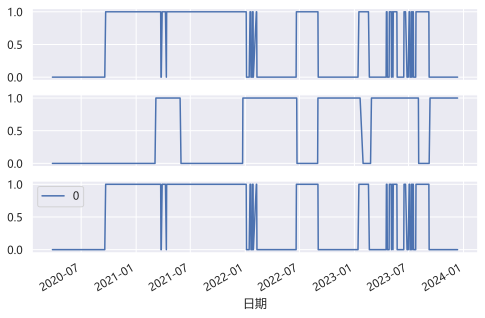

In [45]:
fig, axes = plt.subplots(3,1,figsize=(8,5), gridspec_kw={'height_ratios': [1, 1,1]},sharex = True)
pos_ma.plot(ax=axes[0])
pos_rsi.plot(ax=axes[1])
pos_final.plot(ax=axes[2])

In [46]:
df['lrets_final'] = (pos_final.iloc[:,0] * df.lrets)

/tmp/ipykernel_50089/2944535238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lrets_final'] = (pos_final.iloc[:,0] * df.lrets)


In [47]:

df.fillna(0,inplace=True)

df[['lrets', 'lrets_final']].cumsum().agg(np.exp).tail(5)

/tmp/ipykernel_50089/3761499522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0,inplace=True)


,lrets,lrets_final
日期,,
2023-12-06,2.523810,1.726663
2023-12-07,2.548796,1.726663
2023-12-08,2.534778,1.726663
2023-12-11,2.562153,1.726663
2023-12-12,2.535507,1.726663


<Axes: xlabel='日期'>

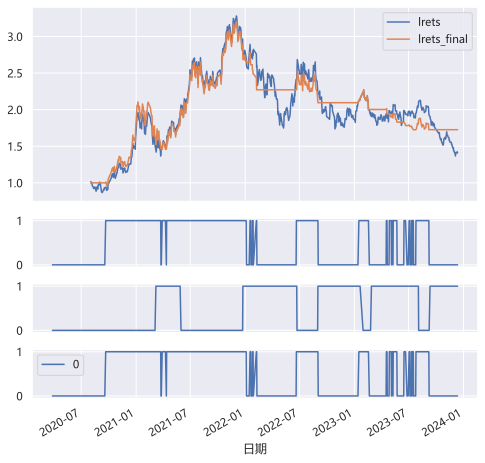

In [48]:
fig, axes = plt.subplots(4,1,figsize=(8,8), gridspec_kw={'height_ratios': [4, 1, 1, 1,]},sharex = True)
df[['lrets', 'lrets_final']].loc['2020-08':].cumsum().agg(np.exp).plot(ax=axes[0])
pos_ma.plot(ax=axes[1])
pos_rsi.plot(ax=axes[2])
pos_final.plot(ax=axes[3])


In [49]:
df[['lrets', 'lrets_final']].loc['2020-08':].agg(sharpe_ratio)

lrets          0.161377
lrets_final    0.378548
dtype: float64

很明显，现有4个参数：均线周期，rsi周期，rsi买入和卖出的阈值，都可以进行优化，各位可以自行摸索。